# Practical Techniques for Discovering Biochemical Models

In [1]:
%matplotlib inline
import numpy as np
import model_fitting as mf
import lecture_analysis as la
import tellurium as te
import matplotlib.pyplot as plt
import pandas as pd
from collections import namedtuple
import lmfit
import os
import re

## Model Description

In [2]:
# Modified model
model_1 = '''
// Created by libAntimony v3.9.4
model *pathway()

  // Compartments and Species:
  species INPUT, P1, mRNA1, P2, mRNA2, P3, mRNA3, P4, mRNA4, P5, mRNA5, P6;
  species mRNA6, P7, mRNA7, P8, mRNA8;

  // Reactions:
  J1:  => mRNA1; L1 + Vm1*((K1_1*INPUT^H1 + K2_1*P4^H1 + K1_1*K3_1*INPUT^H1*P4^H1)/(1 + K1_1*INPUT^H1 + K2_1*P4^H1 + K1_1*K3_1*INPUT^H1*P4^H1)) - d_mRNA1*mRNA1;
  F1:  => P1; a_protein1*mRNA1 - d_protein1*P1;
  J2:  => mRNA2; L2 + Vm2*(K1_2*P4^H2/(1 + K1_2*P4^H2)) - d_mRNA2*mRNA2;
  F2:  => P2; a_protein2*mRNA2 - d_protein2*P2;
  J3:  => mRNA3; L3 + Vm3*(K1_3*P6^H3/(1 + K1_3*P6^H3)) - d_mRNA3*mRNA3;
  F3:  => P3; a_protein3*mRNA3 - d_protein3*P3;
  J4:  => mRNA4; L4 + Vm4*(1/(1 + K1_4*P2^H4)) - d_mRNA4*mRNA4;
  F4:  => P4; a_protein4*mRNA4 - d_protein4*P4;
  J5:  => mRNA5; L5 - d_mRNA5*mRNA5;
  F5:  => P5; a_protein5*mRNA5 - d_protein5*P5;
  J6:  => mRNA6; L6 + Vm6*(K1_6*P7^H6/(1 + K1_6*P7^H6 + K2_6*P1^H6 + K1_6*K2_6*P7^H6*P1^H6)) - d_mRNA6*mRNA6;
  F6:  => P6; a_protein6*mRNA6 - d_protein6*P6;
  J7:  => mRNA7; L7 + Vm7*(K1_7*P1^H7/(1 + K1_7*P1^H7)) - d_mRNA7*mRNA7;  # added term for P1
  F7:  => P7; a_protein7*mRNA7 - d_protein7*P7;
  J8:  => mRNA8; L8 + Vm8*(1/(1 + K1_8*P1^H8)) - d_mRNA8*mRNA8;
  F8:  => P8; a_protein8*mRNA8 - d_protein8*P8;
  '''

In [3]:
# Constants

model_2 = '''

 // Constants to estimate
 Vm7 = 0;
 K1_7 = 0;
 H7 = 0;

 // Species initializations:
  INPUT = 1;
  P1 = 0;
  mRNA1 = 0;
  P2 = 0;
  mRNA2 = 0;
  P3 = 0;
  mRNA3 = 0;
  P4 = 0;
  mRNA4 = 0;
  P5 = 0;
  mRNA5 = 0;
  P6 = 0;
  mRNA6 = 0;
  P7 = 0;
  mRNA7 = 0;
  P8 = 0;
  mRNA8 = 0;

  // Variable initializations:
  d_protein1 = 0.01576525;
  d_mRNA1 = 0.600013;
  L1 = 0.0284569399501349;
  Vm1 = 1.16380673480284;
  a_protein1 = 0.089105566248939;
  H1 = 4.52340391321994;
  K1_1 = 0.0269204907071558;
  K2_1 = 0.0169635567504703;
  K3_1 = 0.0114278645720656;
  d_protein2 = 0.0100753359178861;
  d_mRNA2 = 0.607263145327485;
  
  L2 = 0.01126375;
  Vm2 = 0.855433454948057;
  a_protein2 = 0.0825104648147814;
  H2 = 3.21939257313515;
  K1_2 = 0.0170170903653747;
  
  d_protein3 = 0.0165270958726424;
  d_mRNA3 = 1.4096553751623;
  L3 = 0.0108824170117358;
  Vm3 = 1.61383118795785;
  a_protein3 = 0.118672807163739;
  H3 = 4.57189341195625;
  K1_3 = 0.0133069236136431;
  
  d_protein4 = 0.0205716618573404;
  d_mRNA4 = 1.19069657063437;
  L4 = 0.0142166568749038;
  Vm4 = 0.916251896011744;
  a_protein4 = 0.0862964088164644;
  H4 = 5.00512303222327;
  K1_4 = 0.0179894288457716;
  
  d_protein5 = 0.0180685727313577;
  d_mRNA5 = 0.911653907722886;
  L5 = 0.0124824037745626;
  a_protein5 = 0.106293056264931;
  d_protein6 = 0.0178004316181647;
  
  d_mRNA6 = 0.67287496171115;
  L6 = 0.0166516087433626;
  Vm6 = 0.889302076744445;
  a_protein6 = 0.0890528700251159;
  H6 = 5.58112408673455;
  K1_6 = 0.0139445776013774;
  K2_6 = 0.0121764364668572;
  
  d_protein7 = 0.0206180615545929;
  d_mRNA7 = 0.618711430584466;
  L7 = 0.0178636133026099;
  a_protein7 = 0.0764169841455256;
  
  d_protein8 = 0.0131749080364666;
  d_mRNA8 = 1.17483328491068;
  L8 = 0.0165535374304033;
  Vm8 = 0.87881445337468;
  a_protein8 = 0.103749989801903;
  H8 = 2.17775388441324;
  K1_8 = 0.0168599518440462;

  // Other declarations:
  const d_protein1, d_mRNA1, L1, Vm1, a_protein1, H1, K1_1, K2_1, K3_1, d_protein2;
  const d_mRNA2, L2, Vm2, a_protein2, H2, K1_2, d_protein3, d_mRNA3;
  const L3, Vm3, a_protein3, H3, K1_3, d_protein4, d_mRNA4, L4;
  const Vm4, a_protein4, H4, K1_4, d_protein5, d_mRNA5, L5;
  const a_protein5, d_protein6, d_mRNA6, L6, Vm6, a_protein6;
  const H6, K1_6, K2_6, d_protein7, d_mRNA7, L7, a_protein7;
  const d_protein8, d_mRNA8, L8, Vm8, a_protein8, H8, K1_8;
end
'''

In [9]:
model = model_1 + model_2
# Check the model syntax and consistency
rr = te.loada(model)

## Dataframes in Brief
The ``pandas`` package provides a table abstraction called a data frame.
Dataframes have labels for columns and rows and can be manipulated more easily than numpy arrays.

In [ ]:
# Create a dataframe from a dictionary
df = pd.DataFrame({'a': [1, 2, 3, 4], 'b': [10, 20, 30, 40]}, index=[0.1, 0.2, 0.3, 0.4])
df

In [ ]:
# Creating a new column
df['c'] = df['a'] * df['b']
df

In [ ]:
# Select rows by index value
df[df.index < 0.3]

In [ ]:
# Create a dataframe from a CSV file
df = pd.read_csv("wild.csv")
df

In [ ]:
# Create a dataframe from simulation output
rr = te.loada(model)
data = rr.simulate(0, 1200, 120)
df = pd.DataFrame(data)
df.columns = data.colnames
df.head()

In [ ]:
# Cleaner construction of dataframe for simulation
df = la.simulate(model)
df

## Simplifying Parameter Construction
Instead of 

``
parameters = lmfit.Parameters()
parameters.add(‘Vm7’, min=0.5, max=2)
parameters.add(‘K1_7’, min=0.01, max=0.03)
parameters.add(‘H7’, min=2, max=8)``

We want to use a function.

``
parameters = makeParameters(['Vm7', 'K1_7', 'H7'])``

This means that the function must:

1. know the value ranges for each parameter type
1. determine the parameter type for each name in the list
1. create the parameter with the correct name, min, and max

In [ ]:
# Function skeleton
def makeParameters(names):
    """
    :param list-str names: names of parameters
    :return lmfit.Parameters: 
    """
    # What's the first statement?

### Value ranges for parameter types

**Exercise**: Extend ``makeParameters`` so that the function knows the value ranges.

### Determining Parameter Type

We know the parameter type based on the initial non-numeric string for each name.

- ``Vm7`` is a ``Vm`` type
- ``K1_7`` is a ``K`` type
- ``H7`` is a ``H`` type

We could find the parameter type by examining each character from the start of the name until we encounter a number.
Python provides a better way using regular expressions.

A regular expression is a string pattern.
- ``*`` matches a string with any number of characters, such as ``ab&%`` and the empty string.
- ``+`` matches a string with at least one character
- ``^`` matches the first character in the string
- ``\D`` matches any character that's not a number

So, ``^\D+`` matches if the longest substring of a string that begins at the first character and continues until a number is encountered.


In [ ]:
import re
for constant in ['Vm7', 'K1_7', 'H7']:
    parameter_type = re.findall(r"^\D+", constant)[0]
    print("%s: %s" % (constant, parameter_type))

**Exercise**: Extend ``makeParameters`` to find the parameter type.

**Exercise**: Now that we know the ``min`` and ``max`` for each parameter type and the parameter type for each name, complete ``makeParameters``.

``lecture_analysis.py`` has a complete implementation of ``makeParameters``.

## Residual Analysis

One approach to model discovery is residuals to identify where the model has poor predictions.

In [10]:
# mRNA data for wild type
df_rnaseq = la.cleanColumns(pd.read_csv("wild.csv"))
df_rnaseq.head()

,mRNA1,mRNA2,mRNA3,mRNA4,mRNA5,mRNA6,mRNA7,mRNA8
time,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10.0,0.099307,0.020844,0.007720,0.781444,0.013691,0.084857,2.404909,0.746052
20.0,0.129347,0.041853,0.007983,0.781449,0.014414,1.000481,2.361672,0.688322
30.0,0.241193,0.088704,0.055608,0.781449,0.065749,1.286064,2.248185,0.621902
40.0,0.436952,0.153115,0.357630,0.781445,0.282754,1.326094,2.102741,0.566512


In [7]:
# Simulate the base model, but only collect the mRNA.
df_base_model = la.simulate(model, is_protein=False)
df_base_model.head()

,mRNA1,mRNA2,mRNA3,mRNA4,mRNA5,mRNA6,mRNA7,mRNA8
0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
10.0,0.099374,0.020919,0.00772,0.781444,0.013691,0.024719,0.028816,0.762087
20.0,0.130436,0.042435,0.00772,0.781449,0.013692,0.024747,0.028872,0.761940
30.0,0.245253,0.090163,0.00772,0.781449,0.013692,0.024747,0.028872,0.761423
40.0,0.444409,0.155441,0.00772,0.781447,0.013692,0.024747,0.028872,0.759376


In [13]:
df_res = df_rnaseq - df_base_model
df_res.head()

,mRNA1,mRNA2,mRNA3,mRNA4,mRNA5,mRNA6,mRNA7,mRNA8
0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
10.0,-0.000067,-0.000075,1.362060e-10,-3.528403e-07,-9.249321e-08,0.060138,2.376093,-0.016035
20.0,-0.001089,-0.000583,2.635592e-04,4.150751e-09,7.220312e-04,0.975735,2.332800,-0.073618
30.0,-0.004060,-0.001459,4.788791e-02,1.093697e-08,5.205725e-02,1.261317,2.219313,-0.139520
40.0,-0.007456,-0.002326,3.499099e-01,-2.363899e-06,2.690622e-01,1.301347,2.073869,-0.192865


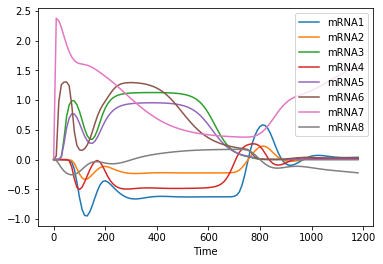

In [14]:
la.plotData(df_res)

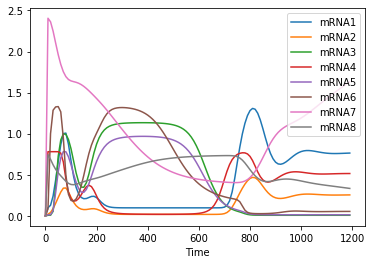

In [16]:
la.plotData(df_rnaseq, endtime=1200)

Observations
1. mRNA1, mRNA7, mRNA8 all rise rapidly. Suggests that mRNA7 has inputs from P1 as does mRNA8.